<a href="https://colab.research.google.com/github/aubricot/object_detection_for_image_cropping/blob/master/image_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image augmentation to diversify and increase the amount of training data for object detection
---
*Last Updated 15 January 2020*   
Image augmentation with the [imgaug library](https://github.com/aleju/imgaug) is used to increase training data sample size and diversity to reduce overfitting when training our object detection model. Instead of creating image annotations from scratch, EOL user-generated cropping coordinates are used and the resulting augmented bounding boxes and images will be converted to the neccessary annotation formats to train YOLO via darkflow, SSD and Faster-RCNN object detection models.

After exporting resulting augmented box coordinates from this notebook, test displaying them using [coordinates_display_test.ipynb](https://colab.research.google.com/github/aubricot/object_detection_for_image_cropping/blob/master/coordinates_display_test.ipynb). If they are not as expected, modify data cleaning steps in the section **Tidy combined dataset** below until the desired results are achieved. 

## Installs
---
Install required libraries directly to this Colab notebook.

In [1]:
# Install libraries for augmenting and displaying images
!pip install imgaug
!pip install pillow
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 102kB/s 
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [2]:
# Mount google drive to import/export files
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Imports   
---

In [3]:
# Change to your image directory within Google Drive
%cd drive/My Drive/fall19_smithsonian_informatics/train/images

# For importing/exporting files, working with arrays, etc
import pathlib
import os
import imageio
import time
import csv
import numpy as np
import pandas as pd
from urllib.request import urlopen
from scipy.misc import imread

# For augmenting the images and bounding boxes
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

# For drawing onto and plotting the images
import matplotlib.pyplot as plt
import cv2
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

/content/drive/My Drive/fall19_smithsonian_informatics/train/images


## Import images and cropping coordinates to be augmented
--- 

In [4]:
# Read in EOL images and user-generated cropping coordinates (used as bounding boxes here)
crops = pd.read_csv('/content/drive/My Drive/fall19_smithsonian_informatics/train/chiroptera_crops.tsv', sep='\t', header=0)
crops.head()

,data_object_id,obj_url,height,width,xmin,ymin,xmax,ymax,name
0,31356195,http://upload.wikimedia.org/wikipedia/commons/...,225,300,35.0100,0.0000,260.0100,225.0000,Chiroptera
1,31364170,http://upload.wikimedia.org/wikipedia/commons/...,2226,2400,0.0000,49.4172,2121.6000,2171.0172,Chiroptera
2,27320132,http://upload.wikimedia.org/wikipedia/commons/...,427,640,267.8400,18.9588,592.5760,343.6948,Chiroptera
3,23364248,http://static.inaturalist.org/photos/239745/or...,1536,2048,0.0000,268.8000,1263.0016,1531.8016,Chiroptera
4,27111698,http://static.inaturalist.org/photos/589510/or...,535,1024,487.3216,219.9920,758.4768,491.1472,Chiroptera


## Augment a single image   
--- 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.


http://upload.wikimedia.org/wikipedia/commons/5/56/Myotis-emarginatus.jpg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


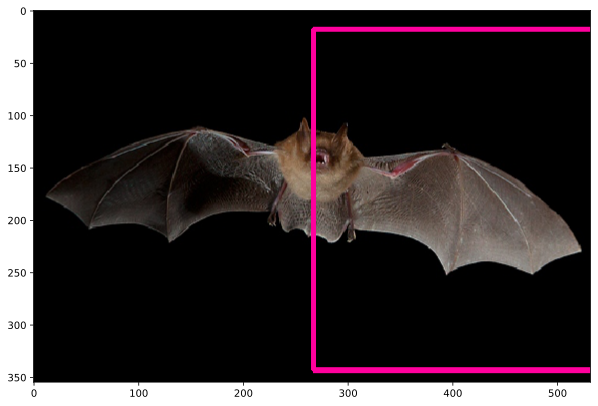

In [5]:
# First display original/un-augmented image and cropping coordinates to test that the libraries are installed properly

# Import image from URL
# Use imread instead of imageio.imread to load images from URL and get consistent output type and shape
i = 2
url = crops.get_value(i, "obj_url")
print(url)
with urlopen(url) as file:
    image = imread(file, mode='RGB') # RGB mode so B/W and color images have same array shape

# Import and reformat bounding box coordinates
bb  = ia.BoundingBox(x1=crops.xmin[2].astype(int), y1=crops.ymin[2].astype(int), 
        x2=crops.xmax[2].astype(int), y2=crops.ymax[2].astype(int))        
bb = BoundingBoxesOnImage([bb], shape=image.shape)

# Draw box on image
imagewbox = cv2.rectangle(image, (bb.bounding_boxes[0].x1, bb.bounding_boxes[0].y1), 
                      (bb.bounding_boxes[0].x2, bb.bounding_boxes[0].y2), 
                      (255, 0, 157), 3)

# Plot image with box
_, ax = plt.subplots(figsize=(10, 10))
ax.imshow(imagewbox)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


http://www.biolib.cz/IMG/GAL/43650.jpg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


Text(0.5, 1.0, '26) Image from http://www.biolib.cz/IMG/GAL/43650.jpg')

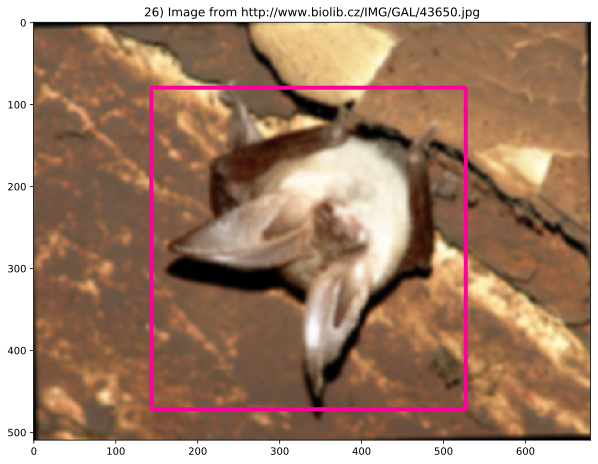

In [0]:
# Next test augmenting a single image and its crop coordinates and display the results

# For image augmentation
from imgaug import augmenters as iaa

# Import image from URL
# Use imread instead of imageio.imread to load images from URL and get consistent output type and shape
i = 2
url = crops.get_value(i, "obj_url")
print(url)
with urlopen(url) as file:
    image = imread(file, mode='RGB')

# Import bounding box coordinates
bb  = ia.BoundingBox(x1=crops.xmin[i].astype(int), y1=crops.ymin[i].astype(int), 
        x2=crops.xmax[i].astype(int), y2=crops.ymax[i].astype(int))        
bb = BoundingBoxesOnImage([bb], shape=image.shape)

# Define image augmentation pipeline
# modified from https://github.com/aleju/imgaug
seq = iaa.Sequential([
    iaa.Crop(px=(1, 16), keep_size=True), # crop by 1-16px, resize resulting image to orig dims
    iaa.Affine(rotate=(-25, 25)), # rotate -25 to 25 degrees
    iaa.GaussianBlur(sigma=(0, 3.0)) # blur using gaussian kernel with sigma of 0-3
])

# Augment image using defined settings in seq
image_aug, bb_aug = seq.augment(image=image, bounding_boxes=bb)

# Draw box on image
imagewbox = cv2.rectangle(image_aug, (bb_aug.bounding_boxes[0].x1.astype(int), bb_aug.bounding_boxes[0].y1.astype(int)), 
                      (bb_aug.bounding_boxes[0].x2.astype(int), bb_aug.bounding_boxes[0].y2.astype(int)), 
                      (255, 0, 157), 3) # change box color and thickness

# Display augmented image and bounding box
_, ax = plt.subplots(figsize=(10, 10))
ax.imshow(imagewbox)
# Show url above image to aid with troubleshooting
plt.title('{}) Image from {}'.format(format(i+1, '.0f'), url))

## Augment multiple images   
---   

In [43]:
# Test augmenting multple images and cropping coordinates and displaying them

# For image augmentation
from imgaug import augmenters as iaa

# For saving images to Google Drive
from scipy import misc

# Set number of seconds to timeout if image url taking too long to open
import socket
socket.setdefaulttimeout(10)

# Optional: set seed to make augmentations reproducible across runs, otherwise will be random each time
ia.seed(1) 

# Define image augmentation pipeline
# modified from https://github.com/aleju/imgaug
seq = iaa.Sequential([
    iaa.Crop(px=(1, 16), keep_size=False), # crop by 1-16px, resize resulting image to orig dims
    iaa.Affine(rotate=(-25, 25)), # rotate -25 to 25 degrees
    iaa.GaussianBlur(sigma=(0, 3.0)) # blur using gaussian kernel with sigma of 0-3
])

# Write header of crops_aug.tsv before looping through crops for remaining data
if os.path.exists('/content/drive/My Drive/fall19_smithsonian_informatics/train'):
        with open('/content/drive/My Drive/fall19_smithsonian_informatics/train/chiroptera_crops_aug.tsv', 'a') as out_file:
            tsv_writer = csv.writer(out_file, delimiter='\t')
            tsv_writer.writerow(["data_object_id",	"obj_url",	"height",	"width",	"xmin",
                                 "ymin",	"xmax",	"ymax",	"filename",	"path",	"name"])

# Loop to perform image augmentation for each image in crops
# First test on 5 images from crops
for i, row in crops.head(5).iterrows():
# Next run on all rows
#for i, row in crops.iterrows():
  try:
    # Import image from url
    # Use imread instead of imageio.imread to load images from url and get consistent output type and shape
    url = crops.get_value(i, "obj_url")
    with urlopen(url) as file:
      image = imread(file, mode='RGB')

    # Import bounding box coordinates
    bb  = ia.BoundingBox(x1=crops.xmin[i].astype(int), y1=crops.ymin[i].astype(int), 
        x2=crops.xmax[i].astype(int), y2=crops.ymax[i].astype(int))        
    bb = BoundingBoxesOnImage([bb], shape=image.shape)
    
    # Augment image using settings defined above in seq
    image_aug, bb_aug = seq.augment(image=image, bounding_boxes=bb)
    
    # Define paths and filenames for augmented and unaugmented images
    pathbase = '/content/drive/My Drive/fall19_smithsonian_informatics/train/images/'
    path = pathbase + str(crops.data_object_id[i]) + '.jpg'
    filename = str(crops.data_object_id[i]) + '.jpg'
    path_aug = pathbase + str(crops.data_object_id[i]) + '_aug' + '.jpg'
    filename_aug = str(crops.data_object_id[i]) + '_aug' + '.jpg'
    
    # Only run this once for all images: export augmented images to Google Drive
    #misc.imsave(path, image_aug)

    # Define image and box augmentation info
    obj_id = crops.data_object_id[i]
    height, width, depth = image_aug.shape
    xmin_aug = bb_aug.bounding_boxes[0].x1.astype(int)
    ymin_aug = bb_aug.bounding_boxes[0].y1.astype(int)
    xmax_aug = bb_aug.bounding_boxes[0].x2.astype(int)
    ymax_aug = bb_aug.bounding_boxes[0].y2.astype(int)
    name = str("Chiroptera")
    
    # Draw augmented bounding box and image
    # Only use this for 20-30 images, otherwise hashtag out
    imagewbox = cv2.rectangle(image_aug, (xmin_aug, ymin_aug), 
                      #(xmax_aug, ymax_aug), 
                      #(255, 0, 157), 3) # change box color and thickness
    _, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(imagewbox)
    plt.title('{}) Successfully augmented image from {}'.format(format(i+1, '.0f'), url))
    
    # Export augmentation results to crops_aug.tsv
    if os.path.exists('/content/drive/My Drive/fall19_smithsonian_informatics/train'):
        with open('/content/drive/My Drive/fall19_smithsonian_informatics/train/chiroptera_crops_aug.tsv', 'a') as out_file:
            tsv_writer = csv.writer(out_file, delimiter='\t')
            tsv_writer.writerow([crops.data_object_id[i], crops.obj_url[i], height, width,
                                 xmin_aug, ymin_aug, xmax_aug, ymax_aug, filename_aug, path_aug, name])
    
    # Display message to track augmentation process by image
    print('{}) Successfully augmented image from {}'.format(format(i+1, '.0f'), url))
  
  except:
    print('{}) Error: check if web address for image from {} is valid'.format(format(i+1, '.0f'), url))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


1) Successfully augmented image from http://upload.wikimedia.org/wikipedia/commons/6/6f/Coleura_seychellensis.png
2) Successfully augmented image from http://upload.wikimedia.org/wikipedia/commons/a/a0/Triaenops_persicus.png
3) Successfully augmented image from http://upload.wikimedia.org/wikipedia/commons/5/56/Myotis-emarginatus.jpg
4) Successfully augmented image from http://static.inaturalist.org/photos/239745/original.jpg?1358932312
5) Successfully augmented image from http://static.inaturalist.org/photos/589510/original.JPG?1385400387
6) Successfully augmented image from http://static.inaturalist.org/photos/589513/original.JPG?1385400458
7) Successfully augmented image from http://upload.wikimedia.org/wikipedia/commons/4/4f/Pteropus_seychellensis.jpg
8) Successfully augmented image from http://upload.wikimedia.org/wikipedia/commons/e/e3/Seychelles_Fruit_Bat_-_Pteropus_seychellensis_2.jpg
9) Successfully augmented image from http://static.inaturalist.org/photos/871507/original.JPG?

## Combine augmented and un-augmented/original bounding boxes and image data
---   

In [44]:
# Create new df with un-augmented/original bounding boxes and images that is formatted the same as the augmented data

# Write header of crops_notaug.tsv before looping through crops for other data
if os.path.exists('/content/drive/My Drive/fall19_smithsonian_informatics/train'):
        with open('/content/drive/My Drive/fall19_smithsonian_informatics/train/chiroptera_crops_notaug.tsv', 'a') as out_file:
            tsv_writer = csv.writer(out_file, delimiter='\t')
            tsv_writer.writerow(["data_object_id",	"obj_url",	"height",	"width",	"xmin",
                                 "ymin",	"xmax",	"ymax",	"filename",	"path",	"name"])

# Loop through crops to get images and bounding boxes
for i, row in crops.iterrows():
  try:
    # Import images from crops
    # Use imread instead of imageio.imread to load images from url and get consistent output type and shape
    url = crops.get_value(i, "obj_url")
    with urlopen(url) as file:
      image = imread(file, mode='RGB')
    height, width, depth = image.shape
    pathbase = '/content/drive/My Drive/fall19_smithsonian_informatics/train/images/'
    path = pathbase + str(crops.data_object_id[i]) + '.jpg'
    filename = str(crops.data_object_id[i]) + '.jpg'
    name = str("Chiroptera")
    
    # Write results to crops_notaug.tsv
    if os.path.exists('/content/drive/My Drive/fall19_smithsonian_informatics/train'):
        with open('/content/drive/My Drive/fall19_smithsonian_informatics/train/chiroptera_crops_notaug.tsv', 'a') as out_file:
            tsv_writer = csv.writer(out_file, delimiter='\t')
            tsv_writer.writerow([crops.data_object_id[i], crops.obj_url[i], height, width, 
                                 crops.xmin[i], crops.ymin[i], crops.xmax[i], crops.ymax[i], filename, path, name])
  except:
    print('{}) Error: check if web address for image from {} is valid'.format(format(i+1, '.0f'), url))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]


16) Error: check if web address for image from http://multimedia.inbio.ac.cr/m3sINBio/getImage?size=big&id=46072 is valid
29) Error: check if web address for image from http://multimedia.inbio.ac.cr/m3sINBio/getImage?size=big&id=6567 is valid
30) Error: check if web address for image from http://multimedia.inbio.ac.cr/m3sINBio/getImage?size=big&id=15872 is valid
31) Error: check if web address for image from http://multimedia.inbio.ac.cr/m3sINBio/getImage?size=big&id=6576 is valid
32) Error: check if web address for image from http://multimedia.inbio.ac.cr/m3sINBio/getImage?size=big&id=46090 is valid
33) Error: check if web address for image from http://multimedia.inbio.ac.cr/m3sINBio/getImage?size=big&id=46061 is valid
34) Error: check if web address for image from http://eolspecies.lifedesks.org/image/view/462/_original is valid
35) Error: check if web address for image from https://conabioweb.conabio.gob.mx/FotoWeb/FWbin/preview.dll/?D=BE1354FC96A6C04C9EE9F8F216382D1ED480CCFB7579B2B

In [45]:
# Combine augmented and un-augmented datasets

# File names to be combined
all_filenames = ["/content/drive/My Drive/fall19_smithsonian_informatics/train/chiroptera_crops_aug.tsv",
                 "/content/drive/My Drive/fall19_smithsonian_informatics/train/chiroptera_crops_notaug.tsv"]

# Combine all files in the list
combined = pd.concat([pd.read_csv(f, sep='\t') for f in all_filenames])

# Export to tsv
combined.to_csv( "/content/drive/My Drive/fall19_smithsonian_informatics/train/chiroptera_crops_all.tsv", index=False, sep='\t')
print(combined.head())

   data_object_id  ...        name
0        31356195  ...  Chiroptera
1        31364170  ...  Chiroptera
2        27320132  ...  Chiroptera
3        23364248  ...  Chiroptera
4        27111698  ...  Chiroptera

[5 rows x 11 columns]


## Tidy combined dataset   
---   

In [46]:
# Read in crops_all.tsv from above
allcrops = pd.read_csv( "/content/drive/My Drive/fall19_smithsonian_informatics/train/chiroptera_crops_all.tsv", sep='\t')
print(allcrops.head())

# Set negative values to 0
allcrops.xmin[allcrops.xmin < 0] = 0
allcrops.ymin[allcrops.ymin < 0] = 0

# Remove out of bounds cropping dimensions
for i, row in allcrops.iterrows():
    # When crop height > image height, set crop height equal to image height:
    if allcrops.ymax[i] > allcrops.height[i]:
            allcrops.ymin[i] = 0
            allcrops.ymax[i] = allcrops.height[i]

for i, row in allcrops.iterrows(): 
    # When crop width > image width, set crop width equal to image width:
    if allcrops.xmax[i] > allcrops.width[i]:
        allcrops.xmin[i] = 0
        allcrops.xmax[i] = allcrops.width[i]

# Write results to tsv
allcrops.to_csv('/content/drive/My Drive/fall19_smithsonian_informatics/train/chiroptera_crops_all_transf.tsv', sep='\t', index=False)

   data_object_id  ...        name
0        31356195  ...  Chiroptera
1        31364170  ...  Chiroptera
2        27320132  ...  Chiroptera
3        23364248  ...  Chiroptera
4        27111698  ...  Chiroptera

[5 rows x 11 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarn